In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-converted-datasets/items.csv
/kaggle/input/english-converted-datasets/sample_submission.csv
/kaggle/input/english-converted-datasets/item_categories.csv
/kaggle/input/english-converted-datasets/sales_train.csv
/kaggle/input/english-converted-datasets/shops.csv
/kaggle/input/english-converted-datasets/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import tensorflow as tf
%matplotlib inline
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense

In [3]:
item_categories_df = pd.read_csv('/kaggle/input/english-converted-datasets/item_categories.csv')

shops_df = pd.read_csv('/kaggle/input/english-converted-datasets/shops.csv')

sales_train_df = pd.read_csv('/kaggle/input/english-converted-datasets/sales_train.csv')

items_df = pd.read_csv('/kaggle/input/english-converted-datasets/items.csv')

test_df = pd.read_csv('/kaggle/input/english-converted-datasets/test.csv')



In [4]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales_train_df.shape

(2935849, 6)

In [6]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [7]:
sales_train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [8]:
sales_train_df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [9]:
sales_train_df['date']=pd.to_datetime(sales_train_df['date'])
sales_train_df['date']

0         2013-02-01
1         2013-03-01
2         2013-05-01
3         2013-06-01
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-09-10
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-03-10
Name: date, Length: 2935849, dtype: datetime64[ns]

In [10]:
sales_train_df['month_year'] = sales_train_df['date'].dt.to_period('M')
sales_train_df['month_year']

0          2013-02
1          2013-03
2          2013-05
3          2013-06
4          2013-01
            ...   
2935844    2015-10
2935845    2015-09
2935846    2015-10
2935847    2015-10
2935848    2015-03
Name: month_year, Length: 2935849, dtype: period[M]

In [11]:
sales_train_df = sales_train_df[sales_train_df['item_price']>0]
sales_train_df = sales_train_df[sales_train_df['item_cnt_day']>0]
sales_train_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month_year
0,2013-02-01,0,59,22154,999.00,1.0,2013-02
1,2013-03-01,0,25,2552,899.00,1.0,2013-03
3,2013-06-01,0,25,2554,1709.05,1.0,2013-06
4,2013-01-15,0,25,2555,1099.00,1.0,2013-01
5,2013-10-01,0,25,2564,349.00,1.0,2013-10
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015-10
2935845,2015-09-10,33,25,7460,299.00,1.0,2015-09
2935846,2015-10-14,33,25,7459,349.00,1.0,2015-10
2935847,2015-10-22,33,25,7440,299.00,1.0,2015-10


In [12]:
monthly_data = sales_train_df.pivot_table(
index= ['shop_id','item_id'],
values=['item_cnt_day'],
columns=['date_block_num'],
fill_value=0,
aggfunc='sum')

In [13]:
monthly_data

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
...                      ...  .. .. .. .. .. .. .. .. ..  ... .. .. .. .. ..   
59      22154              1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22155              0   0  0  0  0  0  1  0  0  0  ...  0  0  0  0  0   
        22162              0   0  0  0  0  0  0  0  0  0  ...  0  9  4  1  1   
        22164              0   0  0  0  0  0  0  0  0  0  ...  0  2  1  2  0   
        22167              0   0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  
...             .. .. .. .. ..  
59      22154    0  0  0  0  0  
        22155    0  0  0  0  0  
        22162    0  0  1  0  0  
        22164    0  1  0  0  0  
        22167    0  0  0  0  0  

[424098 rows x 34 columns]

In [14]:
monthly_data.reset_index(inplace=True)

In [15]:
train_data = monthly_data.drop(columns=['shop_id','item_id'],level=0)
train_data

item_cnt_day                              ...                 \
date_block_num           0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
0                         0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
1                         0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
2                         6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
3                         3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
4                         1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
...                     ...  .. .. .. .. .. .. .. .. ..  ... .. .. .. .. ..   
424093                    1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
424094                    0   0  0  0  0  0  1  0  0  0  ...  0  0  0  0  0   
424095                    0   0  0  0  0  0  0  0  0  0  ...  0  9  4  1  1   
424096                    0   0  0  0  0  0  0  0  0  0  ...  0  2  1  2  0   
424097                    0   0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0   

                               
date_block_num 29 30 31 32 33  
0               0  0  0  0  0  
1               0  0  0  0  0  
2               0  0  0  0  0  
3               0  0  0  0  0  
4               0  0  0  0  0  
...            .. .. .. .. ..  
424093          0  0  0  0  0  
424094          0  0  0  0  0  
424095          0  0  1  0  0  
424096          0  1  0  0  0  
424097          0  0  0  0  0  

[424098 rows x 34 columns]

In [16]:
train_data.fillna(0,inplace=True)

In [17]:
x_train = np.expand_dims(train_data.values[:,:-1],axis=2)
y_train = train_data.values[:,-1:]

In [18]:
test_rows = monthly_data.merge(
test_df,
on=['item_id','shop_id'],
how='right'
)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


In [19]:
test_rows

,item_id,shop_id,"(shop_id, )","(item_id, )","(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)",...,"(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)",ID
0,5037,5,5.0,5037.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,0
1,5320,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,5233,5,5.0,5233.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,2
3,5232,5,5.0,5232.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
4,5268,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,18454,45,45.0,18454.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,214195
214196,16188,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214196
214197,15757,45,45.0,15757.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,214197
214198,19648,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214198


In [20]:
x_test = test_rows.drop(test_rows.columns[:5],axis=1).drop('ID',axis=1)
x_test.fillna(0,inplace=True)

In [21]:
x_test = np.expand_dims(x_test,axis=2)
print(x_train.shape,y_train.shape,x_test.shape)

(424098, 33, 1) (424098, 1) (214200, 33, 1)


In [22]:
model = tf.keras.models.Sequential()
model.add(LSTM(64, input_shape=(33,1),return_sequences=False))

model.add(Dense(1))

model.compile(
    loss='mse',
    optimizer = 'adam',
    metrics = ['mean_squared_error']
)

2022-08-02 20:04:27.251090: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [23]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
#     steps_per_epoch = 100,
    batch_size=4096,
    verbose=1,
    shuffle=True,
    validation_split=0.4
)

2022-08-02 20:04:27.869956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
63/63 [==============================] - 31s 453ms/step - loss: 24.7169 - mean_squared_error: 24.7169 - val_loss: 2.5506 - val_mean_squared_error: 2.5506
Epoch 2/100
63/63 [==============================] - 28s 447ms/step - loss: 24.5407 - mean_squared_error: 24.5407 - val_loss: 2.4652 - val_mean_squared_error: 2.4652
Epoch 3/100
63/63 [==============================] - 28s 448ms/step - loss: 24.4011 - mean_squared_error: 24.4011 - val_loss: 2.4289 - val_mean_squared_error: 2.4289
Epoch 4/100
63/63 [==============================] - 27s 432ms/step - loss: 24.3294 - mean_squared_error: 24.3294 - val_loss: 2.3849 - val_mean_squared_error: 2.3849
Epoch 5/100
63/63 [==============================] - 28s 440ms/step - loss: 24.2581 - mean_squared_error: 24.2581 - val_loss: 2.3553 - val_mean_squared_error: 2.3553
Epoch 6/100
63/63 [==============================] - 28s 444ms/step - loss: 24.1952 - mean_squared_error: 24.1952 - val_loss: 2.3458 - val_mean_squared_error: 2.3458
Epoc

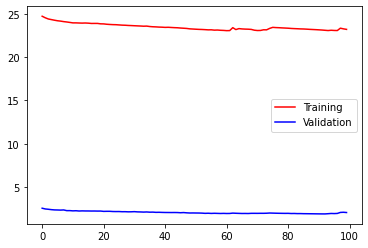

In [24]:
plt.plot(history.history['loss'],color ='r')
plt.plot(history.history['val_loss'],color='b')
plt.legend(['Training','Validation'])
plt.show()

In [25]:
test_predict = model.predict(x_test)
submission = pd.DataFrame({'ID':test_df['ID'],'item_cnt_month':test_predict.ravel()})
submission['item_cnt_month'] = submission['item_cnt_month']
submission.to_csv('submission.csv',index=False)